### Goal
- Input: RGB image.
- Teacher: Depth Anything V2 → predicts a high-quality depth map.
- Student: A smaller, faster model → learns to mimic the teacher’s depth map predictions.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!unzip /content/drive/MyDrive/subway_surfers_preparation.zip
!pip install -U ray[tune]

In [1]:
import torch
from torch import nn
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt
import numpy as np
import os
import random

from ray import tune
from ray import train
from ray.train import Checkpoint, get_checkpoint
from ray.tune.schedulers import ASHAScheduler
import ray.cloudpickle as pickle
import tempfile
from pathlib import Path

from segnet import SegNet

In [2]:
class DepthDataset(torch.utils.data.Dataset):
    def __init__(self, images_dir, depth_maps_dir, transform=None):
        self.images_dir = images_dir
        self.depth_maps_dir = depth_maps_dir
        self.transform = transform

        all_image_files = [f for f in os.listdir(images_dir) if f.lower().endswith('.png')]
        self.files = []
        for image_file in all_image_files:
            depth_file_path = os.path.join(depth_maps_dir, image_file)
            if os.path.exists(depth_file_path):
                self.files.append(image_file)

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        image_path = os.path.join(self.images_dir, self.files[idx])
        depth_map_path = os.path.join(self.depth_maps_dir, self.files[idx])

        image = plt.imread(image_path)
        depth_map = plt.imread(depth_map_path)[:,:,0]

        if self.transform:
            image = self.transform(image)
            depth_map = self.transform(depth_map)

        return image, depth_map

6258 images and depth maps found in dataset.


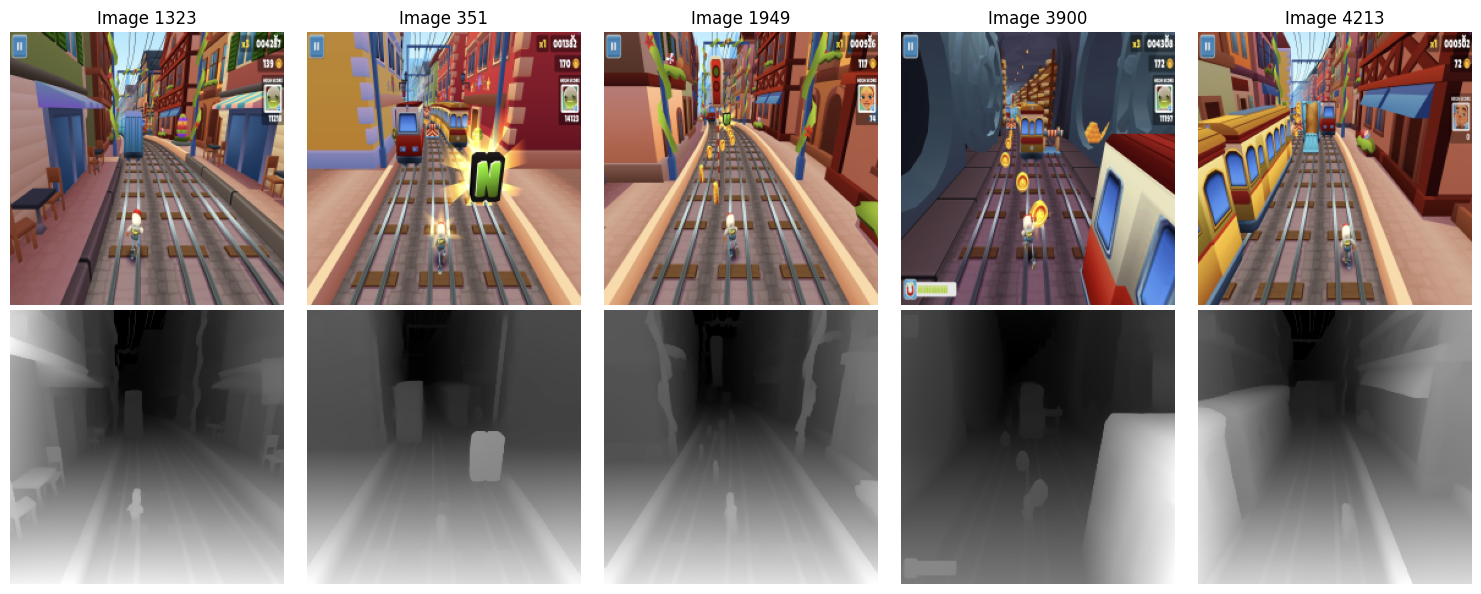

In [3]:
dataset = DepthDataset(
    images_dir='/content/data/depth_data/images',
    depth_maps_dir='/content/data/depth_data/depth_maps',
    transform=ToTensor(),
)

print(dataset.__len__(), "images and depth maps found in dataset.")

# Create a figure with 2 rows and 5 columns
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

# Get 5 random samples from the dataset
indices = np.random.choice(len(dataset), 5, replace=False)

for i, idx in enumerate(indices):
    # Get image and depth map
    image, depth_map = dataset[idx]

    # Convert tensors back to numpy for plotting
    if isinstance(image, torch.Tensor):
        image = image.permute(1, 2, 0).numpy()
    if isinstance(depth_map, torch.Tensor):
        depth_map = depth_map.numpy().squeeze()

    # Plot RGB image in first row
    axes[0, i].imshow(image)
    axes[0, i].set_title(f'Image {idx}')
    axes[0, i].axis('off')

    # Plot depth map in second row
    axes[1, i].imshow(depth_map, cmap='gray')
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()


In [4]:
def train_depth(config):
    model = SegNet(in_channels=3, out_channels=1, features=config["features"])

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=config["lr"])

    checkpoint = get_checkpoint()
    if checkpoint:
        with checkpoint.as_directory() as checkpoint_dir:
            data_path = Path(checkpoint_dir) / "data.pkl"
            with open(data_path, "rb") as fp:
                checkpoint_state = pickle.load(fp)
            start_epoch = checkpoint_state["epoch"]
            model.load_state_dict(checkpoint_state["model_state_dict"])
            optimizer.load_state_dict(checkpoint_state["optimizer_state_dict"])
    else:
        start_epoch = 0

    torch.manual_seed(42)
    dataset = DepthDataset(
        images_dir='/content/data/depth_data/images',
        depth_maps_dir='/content/data/depth_data/depth_maps',
        transform=ToTensor(),
    )
    trainset, valset, _ = torch.utils.data.random_split(dataset, [0.7, 0.15, 0.15])
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=config["batch_size"], shuffle=True, num_workers=0)
    val_loader = torch.utils.data.DataLoader(valset, batch_size=config["batch_size"], shuffle=False, num_workers=0)

    for epoch in range(start_epoch, 100):
        for (X, y) in train_loader:
            X, y = X.to(device).float(), y.to(device).float()

            # zero the parameter gradient
            optimizer.zero_grad()

            # forward + backward + optimize
            model.train()
            y_pred = model(X)
            loss = criterion(y_pred, y)
            loss.backward()
            optimizer.step()

        # validation
        val_loss = 0.0
        val_steps = 0
        for (X, y) in val_loader:
            with torch.inference_mode():
                X, y = X.to(device).float(), y.to(device).float()
                model.eval()
                y_pred = model(X)
                loss = criterion(y_pred, y)
            val_loss += loss.cpu().numpy()
            val_steps += 1

        # Report metrics to Ray Tune
        checkpoint_data = {
            "epoch": epoch,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
        }

        with tempfile.TemporaryDirectory() as checkpoint_dir:
            data_path = Path(checkpoint_dir) / "data.pkl"
            with open(data_path, "wb") as fp:
                pickle.dump(checkpoint_data, fp)

            checkpoint = Checkpoint.from_directory(checkpoint_dir)
            train.report({
                "loss": val_loss / val_steps,
            }, checkpoint=checkpoint)

In [5]:
def test_loss(model):
    torch.manual_seed(42)
    dataset = DepthDataset(
        images_dir='/content/data/depth_data/images',
        depth_maps_dir='/content/data/depth_data/depth_maps',
        transform=ToTensor(),
    )
    _, _, test = torch.utils.data.random_split(dataset, [0.7, 0.15, 0.15])
    test_loader = torch.utils.data.DataLoader(test, batch_size=4, shuffle=False)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    test_loss = 0.0
    test_steps = 0
    with torch.inference_mode():
        for batch, (X, y) in enumerate(test_loader):
            X, y = X.to(device).float(), y.to(device).float()
            model.eval()
            y_pred = model(X)
            test_loss += torch.mean((y_pred.squeeze() - y) ** 2).cpu().numpy()
            test_steps += 1

    return test_loss / test_steps

In [ ]:
num_samples = 24
max_num_epochs = 20
grace_period = 2
reduction_factor = 2

param_space = {
    "features": tune.choice([16, 32]),
    "lr": tune.loguniform(1e-5, 1e-1),
    "batch_size": tune.choice([8, 16, 32])
}

scheduler = ASHAScheduler(
    metric="loss",
    mode="min",
    max_t=max_num_epochs,
    grace_period=grace_period,
    reduction_factor=reduction_factor
)

tune_config = tune.TuneConfig(
    num_samples=num_samples,
    scheduler=scheduler,
)

train_with_resources = tune.with_resources(
    train_depth,
    resources={"cpu": 0.4, "gpu": 0.2}
)

tuner = tune.Tuner(
    train_with_resources,
    tune_config=tune_config,
    param_space=param_space,
    run_config=tune.RunConfig(storage_path="/content/results", name="test_experiment3")
)
result = tuner.fit()

best_result = result.get_best_result("loss", "min", "last")
print(f"Best result config: {best_result.config}")
print(f"Best result final validation loss: {best_result.metrics['loss']}")

best_trained_model = SegNet(in_channels=3, out_channels=1, features=best_result.config["features"])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
best_trained_model.to(device)

best_checkpoint = best_result.checkpoint
with best_checkpoint.as_directory() as checkpoint_dir:
    data_path = Path(checkpoint_dir) / "data.pkl"
    with open(data_path, "rb") as fp:
        best_checkpoint_data = pickle.load(fp)

    best_trained_model.load_state_dict(best_checkpoint_data["model_state_dict"], strict=False)
    test_loss_value = test_loss(best_trained_model)
    print("Best trial test set loss: {}".format(test_loss_value))

    torch.save({
        'model_state_dict': best_trained_model.state_dict(),
        'config': best_result.config,
        'test_loss': test_loss_value
    }, 'best_depth_model.pth')
    torch.save({
        'model_state_dict': best_trained_model.encoder.state_dict(),
        'config': best_result.config,
    }, 'encoder.pth')

In [7]:
def make_predictions(
    model: torch.nn.Module,
    data: list,
    device: torch.device = "cpu"
):
    model.to(device)
    model.eval()
    predictions = []
    with torch.inference_mode():
        for sample in data:
            sample = torch.unsqueeze(sample, dim=0).to(device)
            pred = model(sample)
            pred = pred.squeeze()
            predictions.append(pred)

    return predictions

features: 32
learning rate: 0.00022610811975164026
batch size: 16
loss: 0.03834960609674454


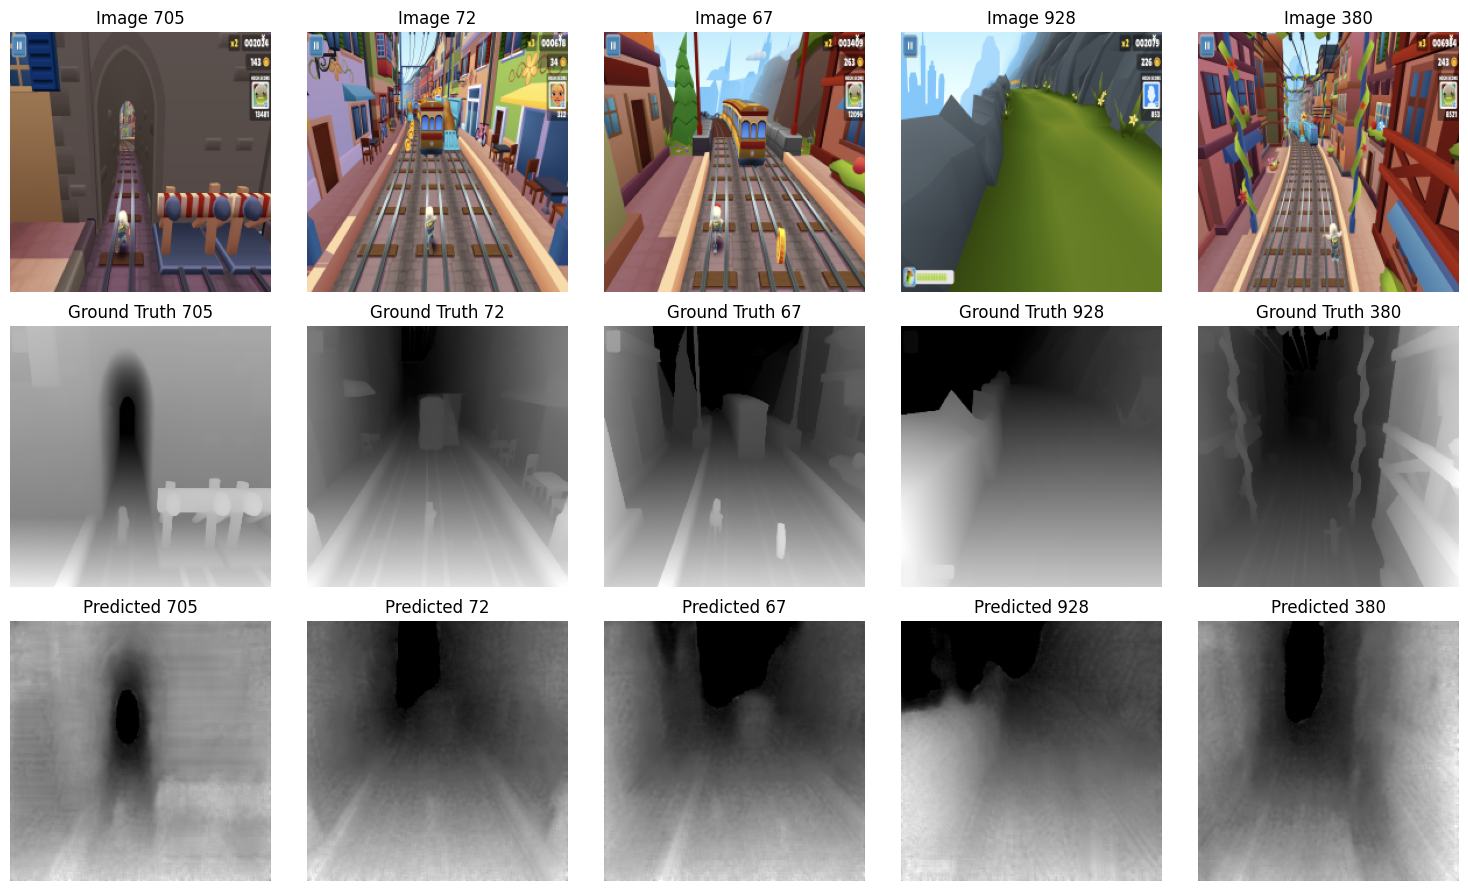

In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

checkpoint = torch.load('best_depth_model.pth', weights_only=False)
model = SegNet(
    in_channels=3,
    out_channels=1,
    features=checkpoint['config']['features']
)
model.load_state_dict(checkpoint['model_state_dict'])
print(f"features: {checkpoint['config']['features']}")
print(f"learning rate: {checkpoint['config']['lr']}")
print(f"batch size: {checkpoint['config']['batch_size']}")
print(f"loss: {checkpoint['test_loss']}")

_, _, testset = torch.utils.data.random_split(dataset, [0.7, 0.15, 0.15])
samples = random.sample(range(len(testset)), 5)
predictions = make_predictions(model, [testset[i][0] for i in samples], device=device)

# Show original image, ground truth depth, and predicted depth
fig, axes = plt.subplots(3, 5, figsize=(15, 9))

for i, idx in enumerate(samples):
    image, depth_map = testset[idx]
    pred = predictions[i].cpu().numpy()

    # Convert tensors back to numpy for plotting
    if isinstance(image, torch.Tensor):
        image = image.permute(1, 2, 0).numpy()
    if isinstance(depth_map, torch.Tensor):
        depth_map = depth_map.numpy().squeeze()

    # Row 1: Original images
    axes[0, i].imshow(image)
    axes[0, i].set_title(f'Image {idx}')
    axes[0, i].axis('off')

    # Row 2: Ground truth depth maps
    axes[1, i].imshow(depth_map, cmap='gray')
    axes[1, i].set_title(f'Ground Truth {idx}')
    axes[1, i].axis('off')

    # Row 3: Predicted depth maps
    axes[2, i].imshow(pred, cmap='gray')
    axes[2, i].set_title(f'Predicted {idx}')
    axes[2, i].axis('off')

plt.tight_layout()
plt.show()